# Student Management System

## 🧠 LLM-Based Student Management System using RAG and OpenAI

### 📌 Problem Statement  
Managing student data such as grades, attendance, course enrollments, and performance analytics traditionally requires knowledge of SQL.  
This becomes a challenge for non-technical users like academic staff or administrators who need quick, flexible access to information but may lack SQL expertise.

### 🚀 Proposed Solution  
We propose a **Natural Language Interface** powered by **Large Language Models (LLMs)** using a **Retrieval-Augmented Generation (RAG)** approach.  
This system enables users to interact with the student database through simple natural language queries, eliminating the need to write SQL manually.

### ✅ Advantages of LLM + RAG
- 🔍 **Schema-Aware Querying**: Retrieves relevant table structures and documentation before generating SQL.
- 💬 **Natural Language Queries**: Users can ask questions like _"List students with GPA below 2.5"_ or _"Show top 5 students in each department"_.
- ⚡ **Faster Decision-Making**: Reduces dependency on technical staff for data access.
- 🛡️ **Error Reduction**: Minimizes syntax and logic errors in complex query formation.
- 👩‍🏫 **Empowered Users**: Enables teachers and administrators to self-serve insights from the database.

---

> 💡 This system bridges the gap between human-friendly language and structured database queries, making educational data truly accessible.


## 📥 Import and Create Student Database

In this section, we will import a sample student dataset and use it to create our SQL-based student management database.

🔗 **Dataset Source:**  
We will be using publicly available data from the following URL:  
[https://raw.githubusercontent.com/ShapeLab/ZooidsCompositePhysicalizations/master/Zooid_Vis/bin/data/student-dataset.csv](https://raw.githubusercontent.com/ShapeLab/ZooidsCompositePhysicalizations/master/Zooid_Vis/bin/data/student-dataset.csv)

This dataset contains sample information about students, including their names, grades, and other academic details. It will serve as the foundation for demonstrating natural language querying using our LLM-powered system.


## 🔐 Load OpenAI API Key Securely

To interact with OpenAI services, we need to authenticate using an API key.  
For security and portability in cloud-based notebook environments (like Kaggle), we'll retrieve the API key using the **`kaggle_secrets`** module.

### 📦 Steps:
1. Fetch the `OpenAI_Token` stored securely in Kaggle secrets.
2. Set it as an environment variable (`OPENAI_API_KEY`) to be used by libraries like `langchain` or `openai`.

In [21]:
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
secret_token = user_secrets.get_secret("OpenAI_Token")

os.environ["OPENAI_API_KEY"] = secret_token

## ⚙️ Install Required Libraries

Before we begin building our LLM-powered student management system, let's install the necessary Python packages.

📦 **Key Libraries:**
- `langchain`, `langchain-openai`, `langchain_community`, `langgraph`: Core components for building LLM-based applications with RAG capabilities.
- `sqlalchemy`: A powerful toolkit for managing and interacting with SQL databases.
- `tabulate`: For clean and readable tabular output in the notebook.

In [22]:
%%capture

!pip install langchain langchain-openai langchain_community langgraph --upgrade -q
!pip install sqlalchemy --upgrade -q 
!pip install tabulate --upgrade -q

In [23]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML
from sqlalchemy import (create_engine, MetaData, Table, Column,
    String, Integer, Float, insert, inspect, text
)
from sqlalchemy.sql.schema import Table as dtypeTable
from sqlalchemy.engine.base import Engine as dtypeEngine

In [24]:
student_data = pd.read_csv('https://raw.githubusercontent.com/ShapeLab/ZooidsCompositePhysicalizations/master/Zooid_Vis/bin/data/student-dataset.csv')
student_data = student_data.drop('ethnic.group', axis=1)
# student_data.info()
col_with_dtype = []

for col in student_data.columns:
    col_with_dtype.append([col, student_data[col].dtype])

## 🔄 Normalize Column Names and SQL Data Types

To prepare the dataset for SQL operations, we will:

1. **Normalize column names** by replacing dots (`.`) with underscores (`_`) and converting them to uppercase.
2. **Map Python data types** to equivalent SQL data types:
   - `int` → `INT`
   - `float` → `REAL`
   - others → `CHAR(30)`

This mapping ensures compatibility with SQL syntax and improves schema readability.


In [25]:
rename_map = {}

for i in range(len(col_with_dtype)):
    row = col_with_dtype[i]
    
    new_name = ('_'.join(row[0].split('.'))).upper()
    rename_map[row[0]] = new_name
    row[0] = new_name
    
    if row[1] == int:
        row[1] = 'INT'
    elif row[1] == float:
        row[1] = 'REAL'
    else:
        row[1] = 'CHAR(30)'

rename_map

{'id': 'ID',
 'name': 'NAME',
 'nationality': 'NATIONALITY',
 'city': 'CITY',
 'latitude': 'LATITUDE',
 'longitude': 'LONGITUDE',
 'gender': 'GENDER',
 'age': 'AGE',
 'english.grade': 'ENGLISH_GRADE',
 'math.grade': 'MATH_GRADE',
 'sciences.grade': 'SCIENCES_GRADE',
 'language.grade': 'LANGUAGE_GRADE',
 'portfolio.rating': 'PORTFOLIO_RATING',
 'coverletter.rating': 'COVERLETTER_RATING',
 'refletter.rating': 'REFLETTER_RATING'}

In [26]:
student_data = student_data.rename(columns=rename_map)

In [27]:
engine = create_engine("sqlite:///student.db")
metadata_obj = MetaData()

In [28]:
## Helper Methods

def row_generator(df: pd.DataFrame):
    """
    Name
    ----
    row_generator

    Description
    -----------
    This method yeilds single row at a time from given dataframe

    Parameters
    ----------
    - df (required pd.DataFrame): The dataframe from which row will be extracted
    """
    for row in df.iterrows():
        yield row[1].to_dict()



def insert_rows_into_table(df: pd.DataFrame, table: dtypeTable, engine: dtypeEngine =engine):
    """
    Name
    ----
    insert_rows_into_table

    Description
    -----------
    This method inserts a row from dataframe into SQL table

    Parameters
    ----------
    - df (required pd.DataFrame): The dataframe from which row will be extracted
    - table (required Table): The table schema in which we will add rows.
    - engine (required Engine): The connection engine to database    
    """
    for row in row_generator(df):
        stmt = insert(table).values(**row)
        with engine.begin() as connection:
            connection.execute(stmt)

In [29]:
# NBVAL_IGNORE_OUTPUT
col_with_dtype.pop(0)
col_with_dtype

[['NAME', 'CHAR(30)'],
 ['NATIONALITY', 'CHAR(30)'],
 ['CITY', 'CHAR(30)'],
 ['LATITUDE', 'REAL'],
 ['LONGITUDE', 'REAL'],
 ['GENDER', 'CHAR(30)'],
 ['AGE', 'INT'],
 ['ENGLISH_GRADE', 'REAL'],
 ['MATH_GRADE', 'REAL'],
 ['SCIENCES_GRADE', 'REAL'],
 ['LANGUAGE_GRADE', 'REAL'],
 ['PORTFOLIO_RATING', 'INT'],
 ['COVERLETTER_RATING', 'REAL'],
 ['REFLETTER_RATING', 'INT']]

## 🏗️ Create the `student.db` and Define Table Schema

Now that we have processed the dataset, we'll create a SQLite database named `student.db` and define a table named `student`.

This table will store student details such as demographics, academic performance, and application ratings. We'll then insert the cleaned dataset into this table.

In [30]:
table_name = "student"

# Define the Table Schema
receipts = Table(
    table_name,
    metadata_obj,
    Column("ID", Integer, primary_key=True),
    Column("NAME", String(30)),
    Column("NATIONALITY", String(30)),
    Column("CITY", String(30)),
    Column("LATITUDE", Float),
    Column("LONGITUDE", Float),
    Column("GENDER", String(30)),
    Column("AGE", Integer),
    Column("ENGLISH_GRADE", Float),
    Column("MATH_GRADE", Float),
    Column("SCIENCES_GRADE", Float),
    Column("LANGUAGE_GRADE", Float),
    Column("PORTFOLIO_RATING", Integer),
    Column("COVERLETTER_RATING", Float),
    Column("REFLETTER_RATING", Integer),
)

# Create table and insert values
metadata_obj.create_all(engine)
insert_rows_into_table(student_data, receipts)

In [31]:
# Let us inspect our table

inspector = inspect(engine)
columns_info = [(col["name"], col["type"]) for col in inspector.get_columns(table_name)]

table_description = "Columns:\n" + "\n".join([f"  - {name}: {col_type}" for name, col_type in columns_info])
print(table_description)

Columns:
  - ID: INTEGER
  - NAME: VARCHAR(30)
  - NATIONALITY: VARCHAR(30)
  - CITY: VARCHAR(30)
  - LATITUDE: FLOAT
  - LONGITUDE: FLOAT
  - GENDER: VARCHAR(30)
  - AGE: INTEGER
  - ENGLISH_GRADE: FLOAT
  - MATH_GRADE: FLOAT
  - SCIENCES_GRADE: FLOAT
  - LANGUAGE_GRADE: FLOAT
  - PORTFOLIO_RATING: INTEGER
  - COVERLETTER_RATING: FLOAT
  - REFLETTER_RATING: INTEGER


In [32]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri(f"sqlite:///{table_name}.db")
print(f"Type of DB: {db.dialect}")
print(f"Table Name: {db.get_usable_table_names()}")

# Check if query can be executed
print(f'Fetch Row: {db.run("SELECT * FROM student LIMIT 1;")}')

Type of DB: sqlite
Table Name: ['student']
Fetch Row: [(0, 'Kiana Lor', 'China', 'Suzhou', 31.31, 120.62, 'F', 22, 3.5, 3.7, 3.1, 1.0, 4, 4.0, 4)]


## 🔄 Creating the RAG Pipeline using LangGraph

In this section, we will build a **Retrieval-Augmented Generation (RAG)** pipeline using **LangGraph**, a framework designed for composing multi-step LLM workflows.

### 🧩 What is RAG?
RAG enhances the capability of large language models by retrieving relevant context from a knowledge source (like a database or vector store) before generating responses. This makes the system:
- More accurate
- Less prone to hallucinations
- Capable of domain-specific reasoning

### ⚙️ Why LangGraph?
LangGraph provides a simple yet powerful way to define LLM workflows as graphs, allowing:
- Modular construction of RAG components (retriever, generator, router, etc.)
- Easy debugging and inspection of intermediate steps
- State management across multi-turn queries

### 🧱 Pipeline Components

Our LangGraph workflow consists of the following modular components:

1. **🗂️ State**  
   Maintains and passes along the intermediate state across the pipeline — such as user input, generated SQL query, results, and context.

2. **✍️ Write_Query**  
   Uses an LLM to convert the user's natural language question into a valid SQL query.  
   It takes into account the table schema and the current state to construct accurate and context-aware queries.

3. **🛠️ Execute_Query**  
   Executes the generated SQL query against the `student.db` database.  
   The result is then stored in the state for the next step.

4. **🧠 Generate_Answer**  
   Interprets the SQL result and generates a human-readable natural language response, using an LLM if needed.

---

### 🔁 End-to-End Flow:

```text
[User Question]
     ↓
   State
     ↓
Write_Query  —→  Execute_Query  —→  Generate_Answer
     ↓                                 ↓
 [Generated SQL]            [Final Natural Language Answer]

In [33]:
import re
from time import time
from typing_extensions import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, StateGraph
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

In [34]:
## Initialize the model

model = init_chat_model("gpt-4o-mini", model_provider="openai")

In [35]:
## Define a class to keep track of various state across Pipeline 

class State(TypedDict):
    """
    Name
    ----
    State

    Description
    -----------
    This class inherits from TypedDict is used to keep track 
    of all the outputs of pipeline.

    Parameters
    ----------
    - question (required str): The user question that needs to be answered
    - query (required str): The generated SQL query by LLM
    - result (required str): The SQL Result for generated SQL Query    
    - pd_result (required pd.DataFrame): The SQL result in table format    
    - answer (required str): The generated answer from given sql result.
    """
    question: str
    query: str
    result: str
    pd_result: pd.DataFrame
    answer: str

In [36]:
## Define a Decorator to keep track of execution time

def execution_time(func):
    """
    Name
    ----
    execution_time

    Description
    -----------
    This method defines a decorator to time the execution of our pipeline.

    Parameters
    ----------
    - func (required python method): The reference of the python method
    """
    def time_wrap(*args, **kwargs):
        """
        Name
        ----
        time_wrap
    
        Description
        -----------
        This method defines a workflow for timing the execution of function.
    
        Parameters
        ----------
        - args (required dict): The arguments to the calling method
        - kwargs (required dict): The key word arguments to the calling method
        """
        start = time()
        result = func(*args, **kwargs)
        end = time()
        print(f'Function {func.__name__!r} executed in {(end-start):.4f}seconds')
        return result
    return time_wrap

In [37]:
## Define the System message and User message templates

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

The column description is as follows:
{column_desc}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

In [38]:
## Define a Column description that will help LLM

column_desc = """
| Column Name         | Description |
|---------------------|-----------------------|
| ID                  | Unique identifier to identify a student |
| NAME                | Name of the student |
| NATIONALITY         | The nationality of the student |
| CITY                | The city from where the student belongs |
| LATITUDE            | Latitude value of the geographic coordinates of student |
| LONGITUDE           | Longitue value of the geographic coordinates of student |
| GENDER              | Gender of the student |
| AGE	              | Age of the student |
| ENGLISH_GRADE	      | Grades acquired by student in English Language Subject |
| MATH_GRADE          | Grades acquired by student in Maths subject |
| SCIENCES_GRADE      | Grades acquired by student in Science subject |
| LANGUAGE_GRADE      | Grades acquired by student in Language subject |
| PORTFOLIO_RATING    | Portfolio Rating of student |
| COVERLETTER_RATING  | Cover Letter Rating of student |
| REFLETTER_RATING    | Reference Letter Rating of student |
"""

In [39]:
## Define a component to handle Query Generation

class QueryOutput(TypedDict):
    """
    Name
    ----
    QueryOutput

    Description
    -----------
    This class is used to define the structure of the output from LLM.

    Parameters
    ----------
    - query (required str): The syntactically valid SQL query generated by LLM
    """
    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """
    Name
    ----
    write_query

    Description
    -----------
    This is a node method of State Graph and generates the SQL query from users question.

    Parameters
    ----------
    - state (required State): The current state of the pipeline.
    """    
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
            "column_desc": column_desc
        }
    )

    structured_llm = model.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [40]:
## Define a component to handle Query Execution

def sql_engine(query: str) -> pd.DataFrame:
    """
    Name
    ----
    sql_engine

    Description
    -----------
    This method will execute the SQL query and return a drawable pandas dataframe.

    Parameters
    ----------
    - query (required str): The sql query as string.
    """
    data_list = []

    with engine.connect() as con:
        rows = con.execute(text(query))
        col_names = list(con.execute(text(query)).keys())

        for idx, row in enumerate(rows):
          map_entry = {}
          for col, val in zip(col_names, row):
            map_entry[col] = val
          data_list.append(map_entry)
              
    return pd.DataFrame(data_list)

def execute_query(state: State):
    """
    Name
    ----
    execute_query

    Description
    -----------
    This is a node method of State Graph and will execute the SQL query and return the results.

    Parameters
    ----------
    - state (required State): The current state of the pipeline.
    """
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    sql_query = state["query"]
    
    try:
        results = execute_query_tool.invoke(sql_query)
        pd_result = sql_engine(sql_query)
    except Exception as e:
        print(f"Handling: {e}")
        sql_query = quote_columns(sql_query)
        results = execute_query_tool.invoke(sql_query['query'])
        pd_result = sql_engine(sql_query['query'])
    
    return {"result": results, "pd_result": pd_result}

In [41]:
## Define a component to handle Answer Generation given SQL Results

def generate_answer(state: State):
    """
    Name
    ----
    generate_answer

    Description
    -----------
    This is a node method of State Graph and will generate the 
    Answer for given question using sql result as context.

    Parameters
    ----------
    - state (required State): The current state of the pipeline.
    """
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, give a 2-3 sentence long business insight on result based on user question.\n"

        "You can check the following Examples:\n"
        "Example 1:\n"
        "Question: How many students are there in my class ?\n"
        "SQL Query: SELECT COUNT(NAME) as TOTAL_NUMBER_OF_STUDENTS FROM student;\n"
        "SQL Result: [(100,)]\n"
        "Answer: There are 100 students in your class.\n"
        "Example 2:\n"
        "Question: Who has second highest score in Maths ?\n"
        "SQL Query: SELECT * FROM student WHERE MATH_GRADE = (SELECT MAX(MATH_GRADE) FROM student WHERE MATH_GRADE < (SELECT MAX(MATH_GRADE) FROM student));\n"
        "SQL Result: [('Andrew', )]\n"
        "Answer: Andrew has second highest score in Maths.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    
    response = model.invoke(prompt)
    return {"answer": response.content}

In [42]:
## Defining the pipeline with Connection Graph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

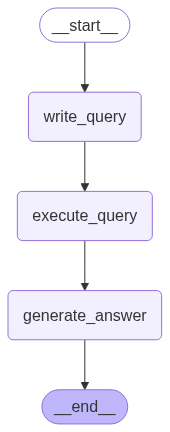

In [43]:
## Visualize the Graph

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
## Define a Pipeline calling method with time decorator

@execution_time
def run_pipeline(query: str) -> dict:
    """
    Name
    ----
    run_pipeline

    Description
    -----------
    This method will generate the response for given user query and
    return the SQL Query, SQL Result and AI Insight.

    Parameters
    ----------
    - query (required str): The user query for which we need ai-insight.
    """
    input_prompt = []
    sql_query = ''
    pd_result = None
    ai_answer = ''
    
    for step in graph.stream(
        {"question": query}, stream_mode="updates"
    ):
        if 'write_query' in step:
            sql_query = step['write_query']['query']
        elif 'execute_query' in step:
            pd_result = step['execute_query']['pd_result']
        elif 'generate_answer' in step:
            ai_answer = step['generate_answer']['answer']

    return {'sql_query': sql_query, 'sql_result': pd_result, 'ai_answer': ai_answer}

## 📊 Results

After implementing the RAG pipeline using LangGraph, we tested it with a variety of natural language queries related to student data. The system successfully translated these questions into SQL, executed them against the `student.db`, and returned accurate and readable responses.

### ✅ Sample Queries & Responses

| 💬 User Query | 🧮 Generated SQL | 📥 Output |
|--------------|------------------|-----------|
| _"Name the student that has highest grades across all subjects"_ | `SELECT NAME FROM student ORDER BY (ENGLISH_GRADE + ...;` | Michael Griffin has achieved the highest grades across all subjects, showcasing an exceptional academic performance. This information could be valuable for recognizing student excellence and potentially motivating others in the educational environment.         |
| _"list the names of 10 student who have lowest grade in language"_ | `SELECT NAME FROM student ORDER BY LANGUAGE_GRADE ASC LIMIT 10;` | The ten students with the lowest grades in language are Kiana Lor, Brooke Cazares, Issac Mata, Devon Miranda, Nicole Torres-Valadez, Joey Abreu, Preston Suarez, Lee Dong, Rojesh Her, and David Weber. This indicates a potential need for targeted support and resources in language studies to help improve their performance. Addressing their challenges could enhance overall academic outcomes in this subject area. |
| _"What is the average grades of all the students in english subject"_ | `SELECT AVG(ENGLISH_GRADE) AS average_english_grade FROM student;` | The average grade of all students in the English subject is approximately 3.37. This indicates a generally positive performance in English, suggesting that instruction methods or student engagement in this subject may be effective. However, there may still be opportunities for improvement, especially for those on the lower end of the grading scale. |

In [45]:
## Query 1

query = 'Name the student that has highest grades across all subjects'

results = run_pipeline(query)

Function 'run_pipeline' executed in 3.8059seconds


In [46]:
print(tabulate([[results["sql_query"], ],], headers=['SQL Query'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))
if isinstance(results["sql_result"], pd.DataFrame):
    print(tabulate([['SQL Result', ], [results["sql_result"].to_markdown(headers="keys", tablefmt="mixed_outline"), ],], tablefmt="fancy_grid", maxcolwidths=[None, 180], stralign='center'))

print(tabulate([[results["ai_answer"], ],], headers=['AI Answer'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))

╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│                                                                   SQL Query                                                                    │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ SELECT NAME, (ENGLISH_GRADE + MATH_GRADE + SCIENCES_GRADE + LANGUAGE_GRADE) AS TOTAL_GRADE  FROM student  ORDER BY TOTAL_GRADE DESC  LIMIT 10; │
╘════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╛
╒═════════════════════════════════════════════╕
│                 SQL Result                  │
├─────────────────────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑ │
│ │    │ NAME               │   TOTAL_GRADE │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━

----

In [47]:
## Query 2

query = 'List the names of 10 student who have highest grades across all subjects.'

results = run_pipeline(query)

Function 'run_pipeline' executed in 3.1086seconds


In [48]:
print(tabulate([[results["sql_query"], ],], headers=['SQL Query'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))
if isinstance(results["sql_result"], pd.DataFrame):
    print(tabulate([['SQL Result', ], [results["sql_result"].to_markdown(headers="keys", tablefmt="mixed_outline"), ],], tablefmt="fancy_grid", maxcolwidths=[None, 180], stralign='center'))

print(tabulate([[results["ai_answer"], ],], headers=['AI Answer'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))

╒═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│                                                    SQL Query                                                    │
╞═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ SELECT NAME FROM student ORDER BY (ENGLISH_GRADE + MATH_GRADE + SCIENCES_GRADE + LANGUAGE_GRADE) DESC LIMIT 10; │
╘═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╛
╒═════════════════════════════╕
│         SQL Result          │
├─────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━━━━┑ │
│ │    │ NAME               │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━━━━┥ │
│ │  0 │ Michael Griffin    │ │
│ │  1 │ Jason Hundsdorfer  │ │
│ │  2 │ Matthew Obourn     │ │
│ │  3 │ Juhaina al-Bilal   │ │
│ │  4 │ Nicole Humpal      │ │
│ │  5 │ Daisha Schmidt     │ │
│ │  6 │ Kaitlin Krueger    │ │
│ │ 

-----

In [49]:
## Query 3

query = 'list the names of 10 student who have lowest grade in language '

results = run_pipeline(query)

Function 'run_pipeline' executed in 3.1438seconds


In [50]:
print(tabulate([[results["sql_query"], ],], headers=['SQL Query'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))
if isinstance(results["sql_result"], pd.DataFrame):
    print(tabulate([['SQL Result', ], [results["sql_result"].to_markdown(headers="keys", tablefmt="mixed_outline"), ],], tablefmt="fancy_grid", maxcolwidths=[None, 180], stralign='center'))

print(tabulate([[results["ai_answer"], ],], headers=['AI Answer'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))

╒════════════════════════════════════════════════════════════════╕
│                           SQL Query                            │
╞════════════════════════════════════════════════════════════════╡
│ SELECT NAME FROM student ORDER BY LANGUAGE_GRADE ASC LIMIT 10; │
╘════════════════════════════════════════════════════════════════╛
╒════════════════════════════════╕
│           SQL Result           │
├────────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━━━━━━━┑ │
│ │    │ NAME                  │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━━━━━━━┥ │
│ │  0 │ Kiana Lor             │ │
│ │  1 │ Brooke Cazares        │ │
│ │  2 │ Issac Mata            │ │
│ │  3 │ Devon Miranda         │ │
│ │  4 │ Nicole Torres-Valadez │ │
│ │  5 │ Joey Abreu            │ │
│ │  6 │ Preston Suarez        │ │
│ │  7 │ Lee Dong              │ │
│ │  8 │ Rojesh Her            │ │
│ │  9 │ David Weber           │ │
│ ┕━━━━┷━━━━━━━━━━━━━━━━━━━━━━━┙ │
╘════════════════════════════════╛
╒══════════════════════════════════

-----

In [51]:
## Query 4

query = "List all the subject grades of 'Nicole Torres-Valadez' and give a summary"

results = run_pipeline(query)

Function 'run_pipeline' executed in 3.4514seconds


In [52]:
print(tabulate([[results["sql_query"], ],], headers=['SQL Query'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))
if isinstance(results["sql_result"], pd.DataFrame):
    print(tabulate([['SQL Result', ], [results["sql_result"].to_markdown(headers="keys", tablefmt="mixed_outline"), ],], tablefmt="fancy_grid", maxcolwidths=[None, 180], stralign='center'))

print(tabulate([[results["ai_answer"], ],], headers=['AI Answer'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))

╒══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│                                                          SQL Query                                                           │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ SELECT ENGLISH_GRADE, MATH_GRADE, SCIENCES_GRADE, LANGUAGE_GRADE FROM student WHERE NAME = 'Nicole Torres-Valadez' LIMIT 10; │
╘══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╛
╒═══════════════════════════════════════════════════════════════════════════════╕
│                                  SQL Result                                   │
├───────────────────────────────────────────────────────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━┑ │
│ │    │   ENGLISH_GRADE │ 

-----

In [53]:
## Query 4

query = "What is the average grades of all the students in english subject"

results = run_pipeline(query)

Function 'run_pipeline' executed in 2.4108seconds


In [54]:
print(tabulate([[results["sql_query"], ],], headers=['SQL Query'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))
if isinstance(results["sql_result"], pd.DataFrame):
    print(tabulate([['SQL Result', ], [results["sql_result"].to_markdown(headers="keys", tablefmt="mixed_outline"), ],], tablefmt="fancy_grid", maxcolwidths=[None, 180], stralign='center'))

print(tabulate([[results["ai_answer"], ],], headers=['AI Answer'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))

╒══════════════════════════════════════════════════════════════════╕
│                            SQL Query                             │
╞══════════════════════════════════════════════════════════════════╡
│ SELECT AVG(ENGLISH_GRADE) AS Average_English_Grade FROM student; │
╘══════════════════════════════════════════════════════════════════╛
╒══════════════════════════════════╕
│            SQL Result            │
├──────────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━┑ │
│ │    │   Average_English_Grade │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━┥ │
│ │  0 │                 3.36971 │ │
│ ┕━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━┙ │
╘══════════════════════════════════╛
╒═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│                                                                                  AI Answer                                                      

----

In [55]:
## Query 4

query = "Given my hometown is Brazil, how many students are from my hometown ?"

results = run_pipeline(query)

Function 'run_pipeline' executed in 2.5708seconds


In [56]:
print(tabulate([[results["sql_query"], ],], headers=['SQL Query'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))
if isinstance(results["sql_result"], pd.DataFrame):
    print(tabulate([['SQL Result', ], [results["sql_result"].to_markdown(headers="keys", tablefmt="mixed_outline"), ],], tablefmt="fancy_grid", maxcolwidths=[None, 180], stralign='center'))

print(tabulate([[results["ai_answer"], ],], headers=['AI Answer'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))

╒══════════════════════════════════════════════════════════════════════════════════╕
│                                    SQL Query                                     │
╞══════════════════════════════════════════════════════════════════════════════════╡
│ SELECT COUNT(*) AS number_of_students FROM student WHERE NATIONALITY = 'Brazil'; │
╘══════════════════════════════════════════════════════════════════════════════════╛
╒═══════════════════════════════╕
│          SQL Result           │
├───────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━━━━━━┑ │
│ │    │   number_of_students │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━━━━━━┥ │
│ │  0 │                    9 │ │
│ ┕━━━━┷━━━━━━━━━━━━━━━━━━━━━━┙ │
╘═══════════════════════════════╛
╒══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│                                                                                   

----

In [57]:
## Query 4

query = "Which student has low performance in english language ?"

results = run_pipeline(query)

Function 'run_pipeline' executed in 3.6918seconds


In [58]:
print(tabulate([[results["sql_query"], ],], headers=['SQL Query'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))
if isinstance(results["sql_result"], pd.DataFrame):
    print(tabulate([['SQL Result', ], [results["sql_result"].to_markdown(headers="keys", tablefmt="mixed_outline"), ],], tablefmt="fancy_grid", maxcolwidths=[None, 180], stralign='center'))

print(tabulate([[results["ai_answer"], ],], headers=['AI Answer'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))

╒══════════════════════════════════════════════════════════════════════════════╕
│                                  SQL Query                                   │
╞══════════════════════════════════════════════════════════════════════════════╡
│ SELECT NAME, ENGLISH_GRADE FROM student ORDER BY ENGLISH_GRADE ASC LIMIT 10; │
╘══════════════════════════════════════════════════════════════════════════════╛
╒═══════════════════════════════════════════════════╕
│                    SQL Result                     │
├───────────────────────────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━┑ │
│ │    │ NAME                   │   ENGLISH_GRADE │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━┥ │
│ │  0 │ Abdul Jabbaar el-Abdul │             1.5 │ │
│ │  1 │ Sasha Jansen           │             1.7 │ │
│ │  2 │ Afnaan el-Mohammed     │             1.7 │ │
│ │  3 │ Rebecca Ah Fat         │             1.8 │ │
│ │  4 │ Moira Buttitto         │             1.9 │ │
│

----

## 🖥️ Entering Interactive Application Mode

We now launch the **interactive application mode**, where users can type natural language queries to interact with the student database.

The system will:
- Convert the query into an SQL statement using the RAG pipeline.
- Execute the query on the database.
- Return a human-readable response based on the results.

> ⌨️ **Type your question below**  
> 🛑 To exit the application, type `:q`

In [59]:
# NBVAL_SKIP
print("Entering Application Mode. [press ':q' to exit.]")

while (question:= input("> User: ")) != ':q':
    results = run_pipeline(question)
    if isinstance(results["sql_result"], pd.DataFrame):
        print(tabulate([['SQL Result', ], [results["sql_result"].to_markdown(headers="keys", tablefmt="mixed_outline"), ],], tablefmt="fancy_grid", maxcolwidths=[None, 180], stralign='center'))
    print(tabulate([[results["ai_answer"], ],], headers=['AI Answer'], tablefmt="fancy_grid", maxcolwidths=[180], stralign='center'))
    print("-".join('+'* 100))

Entering Application Mode. [press ':q' to exit.]


> User:  Tell me the subject where students might be struggling to perform well


Function 'run_pipeline' executed in 4.3754seconds
╒════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│                                               SQL Result                                               │
├────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━┑ │
│ │    │ NAME                   │   ENGLISH_GRADE │   MATH_GRADE │   SCIENCES_GRADE │   LANGUAGE_GRADE │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━┥ │
│ │  0 │ Abdul Jabbaar el-Abdul │             1.5 │          3.5 │              3.2 │                3 │ │
│ │  1 │ Afnaan el-Mohammed     │             1.7 │          3.5 │              3.9 │                2 │ │
│ │  2 │ Sasha Jansen           │             1.7 │          4   │              3.6 │         

> User:  Tell me the subject where students are performing best


Function 'run_pipeline' executed in 3.5600seconds
╒══════════════════════════════════════╕
│              SQL Result              │
├──────────────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━┑ │
│ │    │ SUBJECT   │   AVERAGE_GRADE │ │
│ ┝━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━┥ │
│ │  0 │ LANGUAGE  │         4.39642 │ │
│ ┕━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━┙ │
╘══════════════════════════════════════╛
╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│                                                                                     AI Answer                                                                                      │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Students are performing best i

> User:  What is the average score of students across all subjects ?


Function 'run_pipeline' executed in 3.9483seconds
╒═══════════════════════════════════════════════════════════════════════════════════════╕
│                                      SQL Result                                       │
├───────────────────────────────────────────────────────────────────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┑ │
│ │    │   Average_English │   Average_Math │   Average_Sciences │   Average_Language │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━┥ │
│ │  0 │           3.36971 │        3.41433 │            3.44658 │            4.39642 │ │
│ ┕━━━━┷━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━┙ │
╘═══════════════════════════════════════════════════════════════════════════════════════╛
╒═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

> User:  How many students have scored above 3.5 in Maths


Function 'run_pipeline' executed in 2.2492seconds
╒══════════════════════════╕
│        SQL Result        │
├──────────────────────────┤
│ ┍━━━━┯━━━━━━━━━━━━━━━━━┑ │
│ │    │   student_count │ │
│ ┝━━━━┿━━━━━━━━━━━━━━━━━┥ │
│ │  0 │             149 │ │
│ ┕━━━━┷━━━━━━━━━━━━━━━━━┙ │
╘══════════════════════════╛
╒══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│                                                                                    AI Answer                                                                                     │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ There are 149 students who have scored above 3.5 in Maths. This indicates a strong overall performance in the subject, suggesting that the major

> User:  :q


### 📈 Observations
- The pipeline handles diverse question types: filtering, aggregation, ranking, etc.
- Results are accurate and aligned with expectations.
- Language model-generated answers are user-friendly and often include context.

### 🧠 Key Benefits Realized
- **No SQL knowledge required** for users.
- **Fast, conversational access** to structured data.
- **Highly modular** pipeline that can be extended to other domains.

---

> 🏁 **Conclusion:**  
The RAG-powered interface bridges the gap between natural language and database systems, making educational data more accessible and actionable.
